In [360]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [361]:
from sklearn.datasets import make_classification

x_data_generated, y_data_generated = make_classification(scale=1, random_state=42)

x_data_generated.shape, y_data_generated.shape

((100, 20), (100,))

In [362]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

def cvs_score(x_data, y_data, model=None):
    if model is None:
        model = LogisticRegression()
    return cross_val_score(model, x_data, y_data, scoring='accuracy').mean()

cvs_score(x_data_generated, y_data_generated)

0.9800000000000001

In [363]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.9)
x_data_generated = selector.fit_transform(x_data_generated)
x_data_generated.shape

(100, 14)

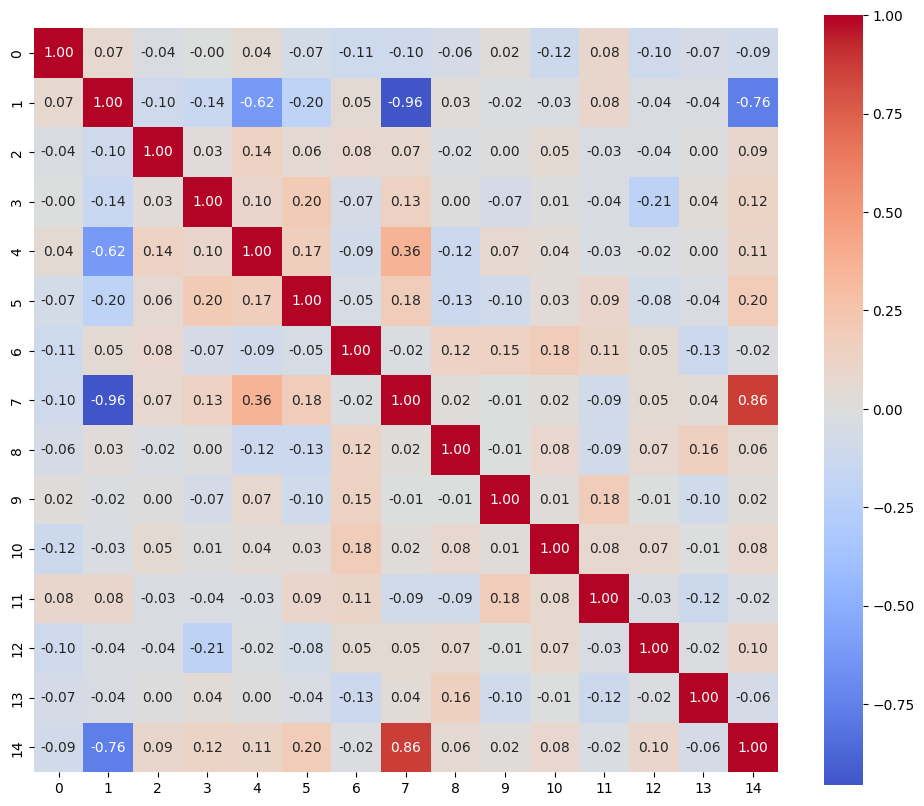

In [364]:
plt.figure(figsize=(12, 10))
stacked_data = np.hstack((x_data_generated, y_data_generated.reshape(-1, 1)))
corr_matrix = np.corrcoef(stacked_data.T)
sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.show()

In [365]:
x_data_generated = np.delete(x_data_generated, 1, axis=1) # удаляем признак сильно скоррелированный с другими признаками (1)
x_data_generated.shape

(100, 13)

Повторите п. 2 на отобранных признаках в п. 3a, п. 3b.

In [366]:
cvs_score(x_data_generated, y_data_generated)

0.96

Осуществите отбор признаков на основе дисперсионного анализа:

In [367]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=5)
x_data_generated2 = selector.fit_transform(x_data_generated, y_data_generated)
x_data_generated2.shape

cvs_score(x_data_generated2, y_data_generated)

1.0

Отбор с использованием моделей:

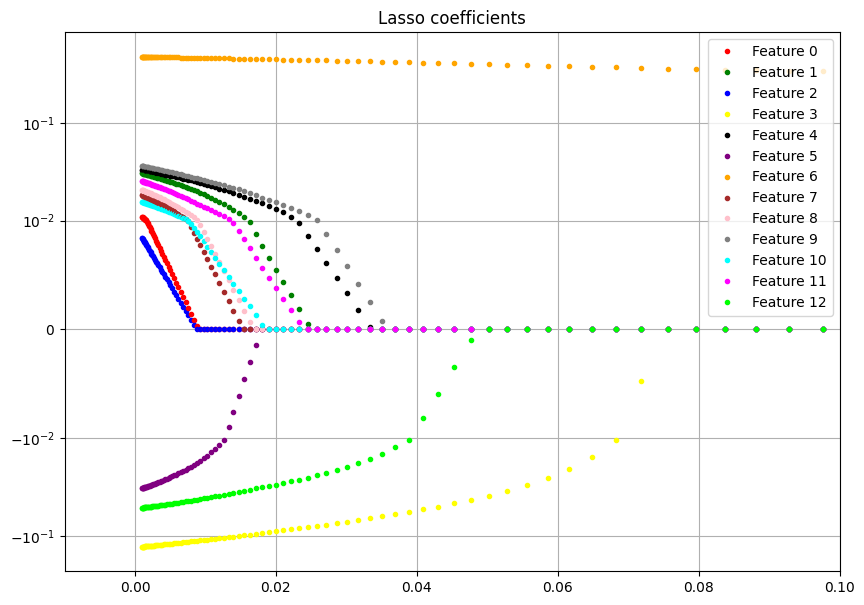

In [368]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

scaler = StandardScaler()
x_data_generated_scaled = scaler.fit_transform(x_data_generated)

model_list = []
coef_list = []

x_test_data = list(2**np.linspace(-10,1,150))
for a in x_test_data:
    model = Lasso(alpha=a, random_state=42)
    model.fit(x_data_generated_scaled, y_data_generated)
    model_list.append(model)
    coef_list.append(model.coef_)

colors = {
    0: "red",
    1: "green",
    2: "blue",
    3: "yellow",
    4: "black",
    5: "purple",
    6: "orange",
    7: "brown",
    8: "pink",
    9: "gray",
    10: "cyan",
    11: "magenta",
    12: "lime",
    13: "teal"
}

plt.figure(figsize=(10, 7))
for i, x in enumerate(x_test_data):
    for j in range(len(coef_list[i])):
        plt.plot(x, coef_list[i][j], 'o', color=colors[j], markersize=3, label='Feature {}'.format(j))
plt.grid()
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict.fromkeys(labels)
handles = [handles[labels.index(label)] for label in unique_labels]
labels = list(unique_labels)
plt.legend(handles, labels, loc='best')
plt.yscale('symlog', linthresh=0.01)
# plt.xscale('symlog', linthresh=0.01)
plt.xlim(-0.01, 0.1)
plt.title('Lasso coefficients')
plt.show()

In [369]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(Lasso(alpha=0.03, random_state=42))
x_data_generated3 = selector.fit_transform(x_data_generated, y_data_generated)
x_data_generated3.shape

cvs_score(x_data_generated3, y_data_generated)

0.9800000000000001

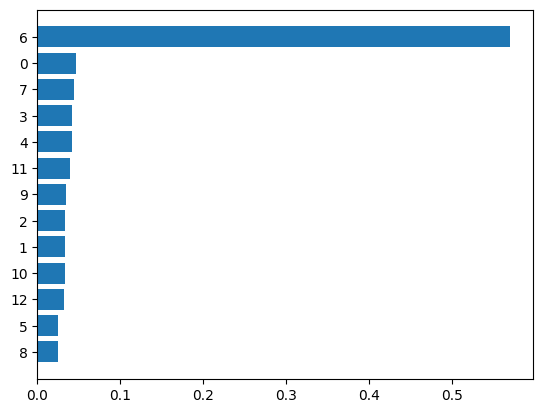

0.95

In [370]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(x_data_generated, y_data_generated)

si = np.argsort(clf.feature_importances_)
le = np.arange(len(clf.feature_importances_))
plt.barh(le, clf.feature_importances_[si])
plt.yticks(ticks=le, labels=[*si])
plt.show()
cvs_score(x_data_generated[:, 6:7], y_data_generated)

In [371]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(clf, n_features_to_select=5, direction="forward")
x_data_generated4 = sfs.fit_transform(x_data_generated, y_data_generated)
display(x_data_generated4.shape)
display(sfs.get_support(indices=True))
cvs_score(x_data_generated4, y_data_generated)

(100, 5)

array([ 1,  2,  3,  6, 12], dtype=int64)

0.99

| Способ выбора признаков                       | Количество признаков | Средняя точность модели |
|------------------------------------------------|----------------------|-------------------------|
| Без выбора признаков                          | 20                   | 0.980                   |
| VarianceThreshold                             | 13                   | 0.960                   |
| SelectKBest (дисперсионный анализ, f_classif) | 5                    | 1.000                   |
| SelectFromModel (Lasso)                       | 8                    | 0.980                   |
| RandomForestClassifier (1 признак)            | 1                    | 0.950                   |
| SequentialFeatureSelector (Random Forest)     | 5                    | 0.990                   |

**Выводы:**
1. **Без выбора признаков**: Модель с 20 признаками показала высокую точность в 0.980.
2. **VarianceThreshold**: Отбор признаков с помощью порога дисперсии оставил 13 признаков и снизил точность до 0.960.
3. **SelectKBest**: Дисперсионный анализ выбрал 5 наиболее значимых признаков, что позволило достичь максимальной точности модели в 1.000.
4. **SelectFromModel (Lasso)**: Этот метод оставил 8 признаков и модель показала точность 0.980.
5. **RandomForestClassifier**: Использование одного самого важного признака по версии случайного леса снизило точность модели до 0.950.
6. **SequentialFeatureSelector (Random Forest)**: Последовательный отбор признаков с использованием случайного леса отобрал 5 признаков и позволил модели достичь высокой точности в 0.990.